In [4]:
import geocoder
import requests
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import math
import cv2
# Get user location dynamically
def get_user_location():
    g = geocoder.ip('me')
    if g.ok:
        return g.latlng  # returns (latitude, longitude)
    return None

# Get nearby places of a specific type (e.g., hospital)
def get_nearby_places(user_location, place_type="hospital", radius_km=5):
    geolocator = Nominatim(user_agent="panic_safety_locator", timeout=10)
    query = f"{place_type} near {user_location[0]}, {user_location[1]}"
    try:
        locations = geolocator.geocode(query, exactly_one=False, limit=5)
    except Exception as e:
        print("Error fetching nearby places:", e)
        return []

    places = []
    if locations:
        for loc in locations:
            place_coords = (loc.latitude, loc.longitude)
            distance_km = geodesic(user_location, place_coords).km
            direction = get_compass_direction(*user_location, *place_coords)
            places.append({
                "name": loc.address,
                "distance_km": round(distance_km, 2),
                "direction": direction,
                "google_maps_link": f"https://www.google.com/maps?q={loc.latitude},{loc.longitude}"
            })

    return places

# Calculate compass direction from coordinates
def get_compass_direction(lat1, lon1, lat2, lon2):
    d_lon = lon2 - lon1
    y = math.sin(math.radians(d_lon)) * math.cos(math.radians(lat2))
    x = (math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) -
         math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.cos(math.radians(d_lon)))
    brng = math.atan2(y, x)
    brng = math.degrees(brng)
    brng = (brng + 360) % 360
    compass_sectors = ['North', 'North-East', 'East', 'South-East',
                       'South', 'South-West', 'West', 'North-West']
    compass_idx = round(brng / 45) % 8
    return compass_sectors[compass_idx]

# Generate calming suggestion from Ollama using nearby places
def get_ollama_suggestion_with_places(places):
    if not places:
        return "Stay calm. Breathe deeply. Try to find a safe space around you."

    points = "\n".join([
        f"{i+1}. {p['name']} — {p['distance_km']} km away, {p['direction']}. Link: {p['google_maps_link']}"
        for i, p in enumerate(places)
    ])

    # Ensure the Google Maps links are included in the prompt
    prompt = (
        "A young woman is experiencing a panic attack. Calm her down with gentle elder-style words. "
        "Then clearly list the nearest safe places around her in point-wise format:\n\n"
        f"{points}\n\n"
        "Do not use paragraphs. Use bullet-style lines only."
    )

    data = {
        "model": "phi3",
        "prompt": prompt,
        "stream": False
    }

    try:
        response = requests.post("http://127.0.0.1:11434/api/generate", json=data)
        result = response.json().get("response", "Stay calm. Help is nearby.")
        return result
    except Exception as e:
        print("Error fetching suggestion from Ollama:", e)
        return "Stay calm. Help is nearby. Find a hospital or police station close to you."

def suggest_safe_places_and_message():
    location = get_user_location()
    if not location:
        print("Could not retrieve location.")
        return

    print(f"Current location: {location}")

    safe_places = get_nearby_places(location, place_type="hospital")
    message = get_ollama_suggestion_with_places(safe_places)

    print("\nSuggestion:\n")
    print(message)

# Run it


In [11]:
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

# Load the pre-trained face detection model (Haar Cascade Classifier)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load your pre-trained model for panic detection
model = load_model('panic_detector_cnn.h5')  # Load your trained model

# Set image size for resizing faces for prediction
img_size = (48,48)  # Adjust as needed
base_threshold = 0.5

In [12]:
def detect_panic(image_path, is_cropped_face=False):
    print(f"\n📷 Processing image: {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Could not load image.")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    panic_detected = False  # Flag for panic

    if is_cropped_face:
        face_resized = cv2.resize(gray, img_size)
        face_normalized = face_resized / 255.0
        face_input = np.expand_dims(face_normalized, axis=(0, -1))

        prediction = model.predict(face_input, verbose=0)[0][0]
        dynamic_threshold = base_threshold
        if prediction < 0.5:
            dynamic_threshold += 0.1
        elif prediction > 0.7:
            dynamic_threshold -= 0.1

        label = "😨 Panic" if prediction > dynamic_threshold else "🙂 Not Panic"
        print(f"🧠 Prediction: {label} (score={prediction:.4f})")

        if prediction > dynamic_threshold:
            panic_detected = True

        plt.figure(figsize=(3, 3))
        plt.title("Cropped Face Input")
        plt.imshow(face_resized, cmap='gray')
        plt.axis('off')
        plt.show()

    else:
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        if len(faces) == 0:
            print("❌ No face detected.")
            return

        print(f"👤 Detected {len(faces)} face(s).")

        for i, (x, y, w, h) in enumerate(faces):
            roi_gray = gray[y:y+h, x:x+w]
            face_resized = cv2.resize(roi_gray, img_size)
            face_normalized = face_resized / 255.0
            face_input = np.expand_dims(face_normalized, axis=(0, -1))

            prediction = model.predict(face_input, verbose=0)[0][0]
            dynamic_threshold = base_threshold
            if prediction < 0.5:
                dynamic_threshold += 0.1
            elif prediction > 0.7:
                dynamic_threshold -= 0.1

            is_panic = prediction > dynamic_threshold
            label = "😨 Panic" if is_panic else "🙂 Not Panic"
            color = (0, 0, 255) if is_panic else (0, 255, 0)

            if is_panic:
                panic_detected = True

            print(f"🧠 Face {i+1} - Prediction: {label} (score={prediction:.4f})")

            cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
            cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

            plt.figure(figsize=(3, 3))
            plt.title(f"Face {i+1} - Grayscale Input")
            plt.imshow(face_resized, cmap='gray')
            plt.axis('off')
            plt.show()

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6, 6))
        plt.title("Prediction Result")
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

    if panic_detected:
        print("\n🛑 Panic detected! Getting calming suggestion...")
        suggestion = suggest_safe_places_and_message()
        print(f"💬 Suggestion: {suggestion}")



📷 Processing image: crowded.jpeg
👤 Detected 1 face(s).
🧠 Face 1 - Prediction: 😨 Panic (score=0.5959)


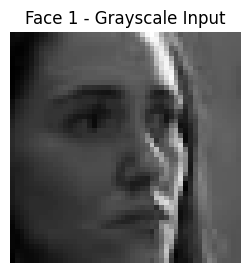

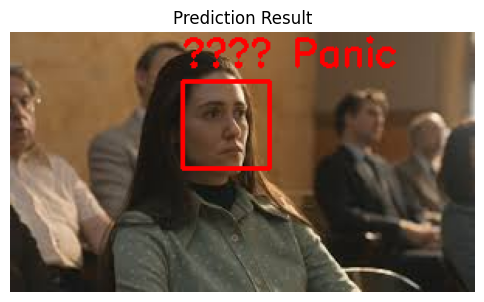


🛑 Panic detected! Getting calming suggestion...
Current location: [17.384, 78.4564]

Suggestion:

Dear friend, please take a deep breath and remember that what you're experiening is temporary discomfort of the mind; nothing more than life’s natural stressors manifesting in your body with nowhere to go but inside itself—trust yourself for it shall pass as quickly as it arose. Here are safe places near you, please proceed directly:
- D.K.GOVT. HOMOEO HOSPITAL at Goshamahal Road & Mangalhat — 0.03 km away in Northwest direction; follow this link for more details https://www.google.com/maps?q=17.3841667,78.4562354
- Apollo Clinic at Masjid e Noor & Mallepally — 0.68 km away in Northeast direction; click here for the map https://www.google.com/maps?q=17.38826565,78.46106549935662
- Healing Touch Hospital at Feroze Gandhi Nagar Road & Vijay Nagar Colony — 0.87 km away in Northwest direction; find more information here https://www.google.com/maps?q=17.3903338,78.4514802
- MNJ Institute of On

In [13]:
detect_panic('crowded.jpeg')


📷 Processing image: crowded.jpeg
👤 Detected 1 face(s).
🧠 Face 1 - Prediction: 😨 Panic (score=0.5959)


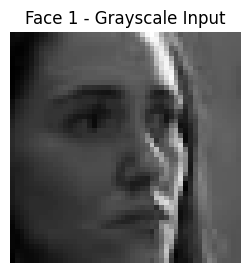

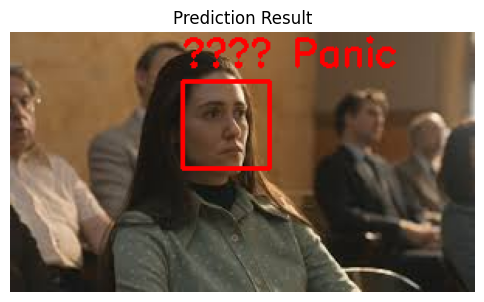


🛑 Panic detected! Getting calming suggestion...
Current location: [17.384, 78.4564]

Suggestion:

Dear friend, please take a deep breath and remember that what you're experiening is temporary discomfort of the mind; nothing more than life’s natural stressors manifesting in your body with nowhere to go but inside itself—trust yourself for it shall pass as quickly as it arose. Here are safe places near you, please proceed directly:
- D.K.GOVT. HOMOEO HOSPITAL at Goshamahal Road & Mangalhat — 0.03 km away in Northwest direction; follow this link for more details https://www.google.com/maps?q=17.3841667,78.4562354
- Apollo Clinic at Masjid e Noor & Mallepally — 0.68 km away in Northeast direction; click here for the map https://www.google.com/maps?q=17.38826565,78.46106549935662
- Healing Touch Hospital at Feroze Gandhi Nagar Road & Vijay Nagar Colony — 0.87 km away in Northwest direction; find more information here https://www.google.com/maps?q=17.3903338,78.4514802
- MNJ Institute of On

In [13]:
detect_panic('crowded.jpeg')

In [1]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import os
app = Flask(__name__)
CORS(app)
@app.route('/process-image', methods=['POST'])
def process_image():
    if 'image' not in request.files:
        return jsonify({'error': 'No image part in request'}), 400

    image = request.files['image']
    filename = image.filename
    save_dir = "uploads"
    os.makedirs(save_dir, exist_ok=True)
    image_path = os.path.join(save_dir, filename)
    image.save(image_path)

    print(f"✅ Image received and saved: {image_path}")

    # 🔍 Call your model here
    result = detect_panic(image_path)

    return jsonify(result), 200

# Run this only if you're in a notebook
app.run(host='0.0.0.0', port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.142.146:5000
Press CTRL+C to quit
192.168.142.146 - - [15/Apr/2025 12:29:10] "GET / HTTP/1.1" 404 -
192.168.142.146 - - [15/Apr/2025 12:29:10] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
import ollama

# Store conversation history with a calming assistant personality
chat_history = [
    {"role": "system", "content": "You are a calming and supportive virtual assistant. \
You are talking to a panicked woman. Respond gently, help her calm down, ask supportive questions, \
and guide her toward safety if needed."}
]

# Function to send a message from the woman and get a reply from Ollama
def chat_with_phi3(message_from_woman):
    chat_history.append({"role": "user", "content": message_from_woman})
    
    response = ollama.chat(
        model="phi3",  # Using Phi-3 model here
        messages=chat_history
    )
    
    assistant_reply = response['message']['content']
    chat_history.append({"role": "assistant", "content": assistant_reply})
    return assistant_reply
    

# Main loop for chat
def panic_support_chat():
    print("👩 Start chatting with the calming assistant. Type 'exit' to end the chat.\n")

    while True:
        user_input = input("Woman 👩: ")
        if user_input.lower() == 'exit':
            print("👋 Ending session. Stay safe.")
            break

        assistant_response = chat_with_phi3(user_input)
        print(f"Ollama 🤖: {assistant_response}\n")

# Run the chat
if __name__ == "__main__":
    panic_support_chat()


👩 Start chatting with the calming assistant. Type 'exit' to end the chat.



Woman 👩:  hii


Ollama 🤖: Hello! I'm sorry to hear that you're feeling this way, but please know that it will be okay. Take a deep breath with me, in for four seconds... hold ... and out. You are safe here. Can you tell me what is making you feel panicked? Maybe we can work through the situation together or find someone who can help if needed.



Woman 👩:  im scared


Ollama 🤖: It's perfectly okay to be frightened, but I want you to know that fear often shows us something important—it means your body is alerting itself to danger. Let’s take it one step at a time together. Can you describe what about this situation makes you feel scared? Sometimes talking through our worries can help make them more manageable.



Woman 👩:  someone is following


Ollama 🤖: Thank you for sharing that with me; feeling unsafe or being followed are serious concerns and it's understandable why that would cause fear. Your safety is my top priority right now. Are there safe places nearby where we can be together while I help address this? Perhaps, if the person still feels too close by after moving to a safer spot with you?

